# 2-Triangle Meshes with no optimal sequence

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

In [2]:
class simplex(object):
    """
    A simplex
    """

    def __init__(self, pts, cbar=1.0):
        """
        INPUTS

        pts: d+1 x d numpy array, each row a vertex of a conforming simplex
        cbar: float wavespeed
        """
        self.pts = pts                # vertex points of simplex
        self.d = pts.shape[1]         # simplex dimension
        self.cbar = cbar              # wave speed
        self.nmls = None              # cached normal vectors
        self.ts = np.zeros(self.d+1)  # current vertex times
        
        # lists of pre-computed matrices, vectors and constants, one list element per vertex
        # see greedyproof.pdf for details
        Ms, Msums, Mdot1s, Ainvs = [], [], [], []
        for i in range(self.d+1):
            At = np.roll(pts - pts[i, :], -(i+1), 0)[:self.d, :]
            Ainvs.append(la.inv(At.T))
            M = la.inv(At@At.T)
            Ms.append(M)
            Mdot1s.append(M.sum(axis=0))
            Msums.append(M.sum())
        self.Ms, self.Msums, self.Mdot1s, self.Ainvs = Ms, Msums, Mdot1s, Ainvs


    def gradtau(self):
        return self.dts(0).dot(self.Ainvs[0])
    
    def theta(self):
        x, y = self.gradtau()
        return np.arctan2(y, x)*180/np.pi
    
    def gtdotn(self, vtx):
        return self.dts(vtx).dot(self.Mdot1s[vtx])
        
    def gradnormsq(self):
        """
        Compute ||∇ τ||²
        """
        dts = self.dts(0)
        return dts.dot(self.Ms[0]).dot(dts)

    def dts(self, ix):
        """
        Compute dtₖ, the vector of time differences relative to vₖ

        INPUTS

        ix: index of reference vertex
        """
        return np.roll(self.ts - self.ts[ix], -(ix+1))[:self.d]

    def kbar(self, ix):
        """
        Compute time increment kbar for vertex ix

        INPUTS

        ts: numpy array with d+1 elements representing vertex times
        """
        M, Msum, Mdot1 = self.Ms[ix], self.Msums[ix], self.Mdot1s[ix]
        c = self.cbar
        dt = self.dts(ix)
        m1dt = Mdot1.dot(dt)
        disc = m1dt**2 - Msum * (dt.dot(M).dot(dt) - 1/c)
        if disc < 0:
            disc = 0.
        return (m1dt + np.sqrt(disc))/Msum


In [7]:
class slab2d(object):
    """
    A tent slab based on a 2D simplicial mesh with 2 triangles
    """

    def __init__(self, cbar=1.0, vpts=None):
        """
        INPUTS
        cbar: float wavespeed, default 1.0
        vpts: 4x2 numpy array representing 4 2D points (if not set
              (if not specified, random vertices are generated)
        """
        self.cbar = cbar
        
        if vpts is None:
            # generate random vertices for the two triangles
            pts1 = np.random.rand(3, 2)
            diffs1 = (pts1 - pts1[0, :])[1:, :]
            if la.det(diffs1) <= 0:
                pts1[[0, 1], :] = pts1[[1, 0], :]

            pts2i = pts1[[0, 2], :]
            pts2 = np.vstack((pts2i, np.random.rand(2)))
            diffs2 = (pts2 - pts2[0, :])[1:, :]
            while la.det(diffs2) <= 0:
                pts2 = np.vstack((pts2i, np.random.rand(2)))
                diffs2 = (pts2 - pts2[0, :])[1:, :]
            self.vpts = np.vstack((pts1, pts2[-1, :]))
        else:
            # use the provided vertices
            self.vpts = vpts
            pts1 = self.vpts[:-1, :]
            pts2 = self.vpts[[0, 2, 3], :]

        # element to vertex and vertex to element maps
        self.v2e = {0: [0, 1], 1: [0], 2: [0, 1], 3: [1]}
        self.e2v = {0: [0, 1, 2], 1: [0, 2, 3]}

        self.els = [simplex(pts1, cbar), simplex(pts2, cbar)]
        self.ts = np.zeros(4)
        self.minstep = 1.0e16

    def elix(self, e, v):
        """
        Return the index of v in the context of element e
        """
        vs = self.e2v[e]
        if v not in vs:
            raise ValueError()
        return vs.index(v)
    
    def gtdotns(self, v):
        return [np.round(self.els[e].gtdotn(self.elix(e, v)),3) for e in self.v2e[v]]
    
    def allgtdotns(self):
        return [self.gtdotns(v) for v in range(4)]
    
    def state(self):
        """
        subtract min time to more easily identify identical states
        """
        return self.ts - min(self.ts)

    def updatets(self, v):
        """
        Update the time for the specified vertex based on global times
        """
        for e in self.v2e[v]:
            ix = self.elix(e, v)
            self.els[e].ts[ix] = self.ts[v]

    def kbars(self, v):
        """
        Given a vertex, compute time increments which would set ||∇ τ|| = 1/cbar
        for each adjacent element.
        """
        result = []
        for e in self.v2e[v]:
            el = self.els[e]
            eix = self.elix(e, v)
            result.append(el.kbar(eix))
        return result
    
    def allkbars(self):
        return [[np.round(k,3)  for k in self.kbars(v)] for v in range(4)]
    
    def isoptimal(self, vtx):
        """
        a vertex is optimal if grad tau is zero for all its elements
        or gtdotn corresponding to its minimal kbar is positive
        """
        if max(e.gradnormsq() for e in self.els) == 0:
            return True
        gtdotns = self.gtdotns(vtx)
        ix = np.argmin(self.kbars(vtx))
        return gtdotns[ix] > 0

    def optimals(self):
        return [self.isoptimal(v) for v in range(4)]
    
    def ktildes(self):
        """
        Compute the time increment for each vertex v such that
        max over elements incident on v of ||∇ τ|| = 1/cbar
        """
        result = []
        for v in range(4):
            kbars = self.kbars(v)
            result.append(min(kbars))
        return result

    def weight(self, vtx):
        """
        function used to weight the ktilde for a vertex in the selection process
        consider:
        1. number of elements incident on the vertex
        2. inverse distance to opposite edge
        3. something with time maybe.  Need to prevent the possibility of both the two single-element
           vertices both being ahead of the double-element vertices in time.  Ok if only one is.
        """
        wt = 0.0
        ne = len(self.v2e[vtx])
        for e in self.v2e[vtx]:
            vix = self.elix(e, vtx)
            term = ne*self.els[e].Msums[vix]
            # print("vtx", vtx, "term", term) 
            wt += term
        return wt

    def step(self, verbose=False, weight=False, vtx=None):
        """
        If weight is True, use the weighting function in the vertex selection process.
        If vtx is not given, select the vertex with maximal ktilde
        and pitch a tent at that vertex.
        If vtx is specified, override to pitch a tent at vtx
        """
        ktildes = self.ktildes()
        if weight:
            prods = [k*self.weight(i) for i, k in enumerate(ktildes)]
            print("prods", prods)
            imax = np.argmax(prods)
        elif vtx is not None:
            imax = vtx
        else:
            imax = np.argmax(ktildes)  # global index of vertex w/ max ktilde
        ktmax = max(0, ktildes[imax])
        if ktmax < self.minstep:
            self.minstep = ktmax
        self.ts[imax] += max(0, ktildes[imax])
        thetas = [e.theta() for e in self.els]
        gradnormsqs = [e.gradnormsq() for e in self.els]
        gtdotns = self.allgtdotns()
        # update times
        self.updatets(imax)
        if verbose:
            print("ktildes", np.array(ktildes))
            print("updated vertex", imax)
            print("new times", self.ts)
            print("minstep", self.minstep)
            
        # preview ktildes for next step, but don't use them to pitch a tent
        ktildes = self.ktildes()
        thetas = [e.theta() for e in self.els]
        gradnormsqs = [e.gradnormsq() for e in self.els]
        allkbars = self.allkbars()
        gtdotns = self.allgtdotns()
        if verbose:
            print("next step preview")
            print(" ktildes", np.array(ktildes))
            print(" kbars", allkbars)
            print(" ∇𝜏⋅𝑛", gtdotns)
            print(" optimal", self.optimals())
        return self.optimals()


    def plot(self):
        """
        Draw the 2 triangle mesh
        """
        fig, ax = plt.subplots()
        ax.set_aspect('equal')
        for el in self.els:
            lpts = np.vstack((el.pts, el.pts[0, :])).tolist()
            ppts = list(zip(*lpts))
            ax.plot(ppts[0], ppts[1], 'g-')
        vpts = self.vpts.tolist()
        ppts = list(zip(*vpts))
        ax.scatter(ppts[0], ppts[1], c='blue')
        for i, pt in enumerate(vpts):
            plt.annotate("  v{}".format(i), pt)
        plt.show()

def traverse(s):
    lvl = 0
    for v in range(4):
        print()
        print("Starting sequence with vertex", v)
        # get a new slab with the same vertices
        s = slab2d(vpts=s.vpts)
        recurse(s, v, lvl+1)
    return s

def recurse(s, v, lvl):
    print("level", lvl, "vtx", v)
    optimals = s.step(vtx=v)
    nz = np.nonzero(optimals)[0]
    if len(nz) == 0:
        print("No optimal vertices - path terminated.")
        return
    else:
        print("Optimal vertices", nz)
        for v in nz:
            recurse(s, v, lvl+1)
    

## Optimal sequences of tent vertices

Let $\overline{k}(v, e)$ for an element e and vertex v, be the non-negative increment to $\tau|_e(v)$ such that
$\nabla \tau'|_e(v) = 1/\overline{c}$.

When $\nabla \tau = 1/\overline{c}$ for an element $e$, we have the simple condition:
$$\overline{k}(v_i, e) > 0 \iff \nabla \tau|_e \cdot n_i > 0.$$  
We say that $\overline{k}$ is 'optimal' if $\nabla \tau \equiv 0$ or $\nabla \tau|_e \cdot n_i > 0$.  Such a value is bounded below by a positive value that depends only on $\overline{c}$ and the geometry of $e$ and can be computed simply by

$$\overline{k}(v_i, e) = \frac{2 \nabla \tau \cdot n_i}{\Sigma M_i} = \frac{ = 2(\mathbf{1}\cdot M_i dt_i^T)}{\Sigma M_i}$$
where $n_i$ is the outer normal vector opposite $v_i$ computed by $dt_i A_i^{-1}$.

However, if $\nabla \tau < 1/\overline{c}$ for an element $e$, $\overline{k}$ is positive for every vertex of $e$, but only those vertices $v_i$ which satisfy $\nabla \tau \cdot n_i > 0$ whenever $\nabla \tau \neq 0$ are optimal.

Now we define $\tilde{k}$ for a vertex $v_i$ as the minimum of its $\overline{k}$ values over its elements.  We say that $\tilde{k}$ is 'optimal' if a minimal $\overline{k}$ value for $v_i$ satisfies $\nabla \tau \cdot n_i > 0$ whenever $\nabla \tau \neq 0$ 

## Examples of a 2-triangle mesh with no optimal sequence

We have seen examples of 2-triangle meshes for which the Greedy II algorithm fails.  But that algorithm defines a *specific sequence* of vertices with large, though not necessarily optimal, $\tilde{k}$ values by selecting at each step the next vertex as the one with maximal $\tilde{k}$.   But many other sequences are possible.  In fact, we have been able to generate optimal sequences, which appear to continue indefinitely, for each of the examples in the 'Mesh2Triangles' notebook. The question naturally arises:  

For an arbitrary simplicial mesh, does there exist an infinite sequence of optimal vertices?  The answer is no.

We give examples of 2-triangle meshes such that there is no infinite sequence of 'optimal vertices'.

We don't consider sequences containing non-optimal $\tilde{k}$ values, since for such sequences, the time increments could become arbitrarily small, thus yielding an infinite sequence which only extends to a finite time slab.

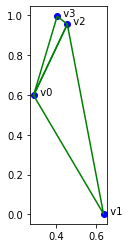

In [4]:






vpts = np.array([[0.2861798 , 0.59793209],
       [0.63771079, 0.00240717],
       [0.45567868, 0.95506259],
       [0.40467456, 0.99532401]])

s = slab2d(vpts=vpts)
s.plot()

## Traverse the tree of all possible sequences of optimal vertices

In [5]:
traverse(s)


Starting sequence with vertex 0
level 1 vtx 0
Optimal vertices [1 2]
level 2 vtx 1
Optimal vertices [0 2]
level 3 vtx 0
Optimal vertices [2]
level 4 vtx 2
Optimal vertices [3]
level 5 vtx 3
Optimal vertices [2]
level 6 vtx 2
Optimal vertices [3]
level 7 vtx 3
Optimal vertices [2]
level 8 vtx 2
Optimal vertices [3]
level 9 vtx 3
Optimal vertices [2]
level 10 vtx 2
Optimal vertices [0 3]
level 11 vtx 0
Optimal vertices [3]
level 12 vtx 3
Optimal vertices [2]
level 13 vtx 2
Optimal vertices [0 3]
level 14 vtx 0
Optimal vertices [3]
level 15 vtx 3
Optimal vertices [2]
level 16 vtx 2
Optimal vertices [0 3]
level 17 vtx 0
Optimal vertices [3]
level 18 vtx 3
Optimal vertices [2]
level 19 vtx 2
Optimal vertices [0 3]
level 20 vtx 0
Optimal vertices [1 3]
level 21 vtx 1
Optimal vertices [3]
level 22 vtx 3
No optimal vertices - path terminated.
level 21 vtx 3
No optimal vertices - path terminated.
level 20 vtx 3
No optimal vertices - path terminated.
level 17 vtx 3
No optimal vertices - path te

## A sequence in detail

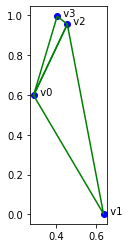

In [8]:
vpts = np.array([[0.2861798 , 0.59793209],
       [0.63771079, 0.00240717],
       [0.45567868, 0.95506259],
       [0.40467456, 0.99532401]])

s = slab2d(vpts=vpts)
s.plot()

In [9]:
s.step(True, vtx=0);

ktildes [0.234 0.573 0.06  0.063]
updated vertex 0
new times [0.234 0.    0.    0.   ]
minstep 0.23351418561348344
next step preview
 ktildes [0.    0.925 0.063 0.043]
 kbars [[0.0, 0.152], [0.925], [0.617, 0.063], [0.043]]
 ∇𝜏⋅𝑛 [[-4.282, -1.573], [1.408], [2.874, 3.708], [-2.135]]
 optimal [False, True, True, False]


In [10]:
s.step(True, vtx=1)

ktildes [0.    0.925 0.063 0.043]
updated vertex 1
new times [0.234 0.925 0.    0.   ]
minstep 0.23351418561348344
next step preview
 ktildes [0.141 0.    0.025 0.043]
 kbars [[0.141, 0.152], [0.0], [0.025, 0.063], [0.043]]
 ∇𝜏⋅𝑛 [[1.294, -1.573], [-1.408], [0.115, 3.708], [-2.135]]
 optimal [True, False, True, False]


[True, False, True, False]

In [1616]:
s.step(True, vtx=0)

ktildes [0.141 0.    0.025 0.043]
updated vertex 0
new times [0.375 0.925 0.    0.   ]
minstep 0.1411027910280955
next step preview
 ktildes [0.    0.    0.048 0.006]
 kbars [[0.0, 0.011], [0.0], [0.397, 0.048], [0.006]]
 grad tau dot n [[-1.294, -2.523], [-0.557], [1.851, 5.949], [-3.426]]
 optimals [False, False, True, False]


[False, False, True, False]

In [1617]:
s.step(True, vtx=2)

ktildes [0.    0.    0.048 0.006]
updated vertex 2
new times [0.375 0.925 0.048 0.   ]
minstep 0.04758266808317875
next step preview
 ktildes [-0.     0.092 -0.     0.071]
 kbars [[0.061, -0.0], [0.092], [0.35, -0.0], [0.071]]
 grad tau dot n [[-0.708, -1.767], [-0.699], [1.408, -7.102], [8.869]]
 optimals [False, False, False, True]


[False, False, False, True]

In [1618]:
s.step(True, vtx=3)

ktildes [-0.     0.092 -0.     0.071]
updated vertex 3
new times [0.375 0.925 0.048 0.071]
minstep 0.04758266808317875
next step preview
 ktildes [-0.     0.092  0.082  0.   ]
 kbars [[0.061, -0.0], [0.092], [0.35, 0.082], [0.0]]
 grad tau dot n [[-0.708, -2.418], [-0.699], [1.408, 11.287], [-8.869]]
 optimals [False, False, True, False]


[False, False, True, False]

In [1619]:
s.step(True, vtx=2)

ktildes [-0.     0.092  0.082  0.   ]
updated vertex 2
new times [0.375 0.925 0.13  0.071]
minstep 0.04758266808317875
next step preview
 ktildes [-0.     0.14  -0.     0.099]
 kbars [[0.15, -0.0], [0.14], [0.267, -0.0], [0.099]]
 grad tau dot n [[0.305, -1.111], [-0.945], [0.64, -11.287], [12.399]]
 optimals [False, False, False, True]


[False, False, False, True]

In [1620]:
s.step(True, vtx=3)

ktildes [-0.     0.14  -0.     0.099]
updated vertex 3
new times [0.375 0.925 0.13  0.171]
minstep 0.04758266808317875
next step preview
 ktildes [-0.     0.14   0.105 -0.   ]
 kbars [[0.15, -0.0], [0.14], [0.267, 0.105], [-0.0]]
 grad tau dot n [[0.305, -2.021], [-0.945], [0.64, 14.42], [-12.399]]
 optimals [False, False, True, False]


[False, False, True, False]

In [1621]:
s.step(True, vtx=2)

ktildes [-0.     0.14   0.105 -0.   ]
updated vertex 2
new times [0.375 0.925 0.235 0.171]
minstep 0.04758266808317875
next step preview
 ktildes [-0.     0.123  0.     0.119]
 kbars [[0.251, -0.0], [0.123], [0.162, 0.0], [0.119]]
 grad tau dot n [[1.599, -0.351], [-1.259], [-0.34, -14.42], [14.771]]
 optimals [False, False, False, True]


[False, False, False, True]

In [1622]:
s.step(True, vtx=3)

ktildes [-0.     0.123  0.     0.119]
updated vertex 3
new times [0.375 0.925 0.235 0.289]
minstep 0.04758266808317875
next step preview
 ktildes [ 0.     0.123  0.118 -0.   ]
 kbars [[0.251, 0.0], [0.123], [0.162, 0.118], [-0.0]]
 grad tau dot n [[1.599, -1.435], [-1.259], [-0.34, 16.206], [-14.771]]
 optimals [False, False, True, False]


[False, False, True, False]

In [1623]:
s.step(True, vtx=2)

ktildes [ 0.     0.123  0.118 -0.   ]
updated vertex 2
new times [0.375 0.925 0.353 0.289]
minstep 0.04758266808317875
next step preview
 ktildes [0.131 0.043 0.    0.126]
 kbars [[0.355, 0.131], [0.043], [0.044, 0.0], [0.126]]
 grad tau dot n [[3.053, 0.441], [-1.612], [-1.442, -16.206], [15.764]]
 optimals [True, False, False, True]


[True, False, False, True]

In [1624]:
s.step(True, vtx=0)

ktildes [0.131 0.043 0.    0.126]
updated vertex 0
new times [0.506 0.925 0.353 0.289]
minstep 0.04758266808317875
next step preview
 ktildes [-0.     0.259  0.     0.117]
 kbars [[0.224, -0.0], [0.259], [0.279, 0.0], [0.117]]
 grad tau dot n [[0.649, -0.441], [-0.821], [0.172, -14.124], [14.566]]
 optimals [False, False, False, True]


[False, False, False, True]

In [1625]:
s.step(True, vtx=3)

ktildes [-0.     0.259  0.     0.117]
updated vertex 3
new times [0.506 0.925 0.353 0.406]
minstep 0.04758266808317875
next step preview
 ktildes [ 0.     0.259  0.117 -0.   ]
 kbars [[0.224, 0.0], [0.259], [0.279, 0.117], [-0.0]]
 grad tau dot n [[0.649, -1.51], [-0.821], [0.172, 16.076], [-14.566]]
 optimals [False, False, True, False]


[False, False, True, False]

In [1626]:
s.step(True, vtx=2)

ktildes [ 0.     0.259  0.117 -0.   ]
updated vertex 2
new times [0.506 0.925 0.47  0.406]
minstep 0.04758266808317875
next step preview
 ktildes [0.104 0.186 0.    0.126]
 kbars [[0.32, 0.104], [0.186], [0.162, 0.0], [0.126]]
 grad tau dot n [[2.092, 0.351], [-1.171], [-0.921, -16.076], [15.725]]
 optimals [True, False, False, True]


[True, False, False, True]

In [1627]:
s.step(True, vtx=0)

ktildes [0.104 0.186 0.    0.126]
updated vertex 0
new times [0.61  0.925 0.47  0.406]
minstep 0.04758266808317875
next step preview
 ktildes [0.    0.358 0.    0.119]
 kbars [[0.216, 0.0], [0.358], [0.331, 0.0], [0.119]]
 grad tau dot n [[0.179, -0.351], [-0.542], [0.362, -14.42], [14.771]]
 optimals [False, False, False, True]


[False, False, False, True]

In [1628]:
s.step(True, vtx=3)

ktildes [0.    0.358 0.    0.119]
updated vertex 3
new times [0.61  0.925 0.47  0.525]
minstep 0.04758266808317875
next step preview
 ktildes [ 0.     0.358  0.118 -0.   ]
 kbars [[0.216, 0.0], [0.358], [0.331, 0.118], [-0.0]]
 grad tau dot n [[0.179, -1.435], [-0.542], [0.362, 16.206], [-14.771]]
 optimals [False, False, True, False]


[False, False, True, False]

In [1629]:
s.step(True, vtx=2)

ktildes [ 0.     0.358  0.118 -0.   ]
updated vertex 2
new times [0.61  0.925 0.589 0.525]
minstep 0.04758266808317875
next step preview
 ktildes [0.131 0.279 0.    0.126]
 kbars [[0.308, 0.131], [0.279], [0.212, 0.0], [0.126]]
 grad tau dot n [[1.634, 0.441], [-0.894], [-0.739, -16.206], [15.764]]
 optimals [True, False, False, True]


[True, False, False, True]

In [1630]:
s.step(True, vtx=0)

ktildes [0.131 0.279 0.    0.126]
updated vertex 0
new times [0.741 0.925 0.589 0.525]
minstep 0.04758266808317875
next step preview
 ktildes [ 0.     0.495 -0.     0.117]
 kbars [[0.177, 0.0], [0.495], [0.41, -0.0], [0.117]]
 grad tau dot n [[-0.77, -0.441], [-0.104], [0.874, -14.124], [14.566]]
 optimals [False, False, False, True]


[False, False, False, True]

In [1631]:
s.step(True, vtx=3)

ktildes [ 0.     0.495 -0.     0.117]
updated vertex 3
new times [0.741 0.925 0.589 0.641]
minstep 0.04758266808317875
next step preview
 ktildes [-0.     0.495  0.117 -0.   ]
 kbars [[0.177, -0.0], [0.495], [0.41, 0.117], [-0.0]]
 grad tau dot n [[-0.77, -1.51], [-0.104], [0.874, 16.076], [-14.566]]
 optimals [False, False, True, False]


[False, False, True, False]

In [1632]:
s.step(True, vtx=2)

ktildes [-0.     0.495  0.117 -0.   ]
updated vertex 2
new times [0.741 0.925 0.706 0.641]
minstep 0.04758266808317875
next step preview
 ktildes [ 0.104  0.422 -0.     0.126]
 kbars [[0.264, 0.104], [0.422], [0.292, -0.0], [0.126]]
 grad tau dot n [[0.672, 0.351], [-0.454], [-0.219, -16.076], [15.725]]
 optimals [True, False, False, True]


[True, False, False, True]

In [1633]:
s.step(True, vtx=0)

ktildes [ 0.104  0.422 -0.     0.126]
updated vertex 0
new times [0.845 0.925 0.706 0.641]
minstep 0.04758266808317875
next step preview
 ktildes [ 0.     0.594 -0.     0.119]
 kbars [[0.16, 0.0], [0.594], [0.44, -0.0], [0.119]]
 grad tau dot n [[-1.241, -0.351], [0.175], [1.065, -14.42], [14.771]]
 optimals [False, True, False, True]


[False, True, False, True]

In [1634]:
s.step(True, vtx=1)

ktildes [ 0.     0.594 -0.     0.119]
updated vertex 1
new times [0.845 1.518 0.706 0.641]
minstep 0.04758266808317875
next step preview
 ktildes [ 0.     0.    -0.     0.119]
 kbars [[0.255, 0.0], [0.0], [-0.0, -0.0], [0.119]]
 grad tau dot n [[2.34, -0.351], [-1.633], [-0.707, -14.42], [14.771]]
 optimals [False, False, False, True]


[False, False, False, True]

In [1635]:
s.step(True, vtx=3)

ktildes [ 0.     0.    -0.     0.119]
updated vertex 3
new times [0.845 1.518 0.706 0.76 ]
minstep 0.04758266808317875
next step preview
 ktildes [ 0.  0. -0.  0.]
 kbars [[0.255, 0.0], [0.0], [-0.0, 0.118], [0.0]]
 grad tau dot n [[2.34, -1.435], [-1.633], [-0.707, 16.206], [-14.771]]
 optimals [False, False, False, False]


[False, False, False, False]

## Another example
The longest optimal sequence for this 2-triangle mesh terminates after 93 steps

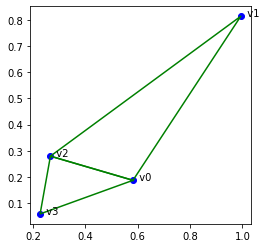

In [8]:
vpts = np.array([[0.58228029, 0.18701104],
       [0.99382862, 0.81330621],
       [0.26723904, 0.27925846],
       [0.22784489, 0.05875047]])

s = slab2d(vpts=vpts)
s.plot()

In [10]:
s = traverse(s)


Starting sequence with vertex 0
level 1 vtx 0
Optimal vertices [1 2 3]
level 2 vtx 1
Optimal vertices [2 3]
level 3 vtx 2
Optimal vertices [3]
level 4 vtx 3
No optimal vertices - path terminated.
level 3 vtx 3
No optimal vertices - path terminated.
level 2 vtx 2
Optimal vertices [0]
level 3 vtx 0
Optimal vertices [1 2]
level 4 vtx 1
Optimal vertices [2]
level 5 vtx 2
Optimal vertices [3]
level 6 vtx 3
Optimal vertices [0]
level 7 vtx 0
Optimal vertices [2]
level 8 vtx 2
Optimal vertices [0 3]
level 9 vtx 0
Optimal vertices [1 2 3]
level 10 vtx 1
Optimal vertices [2 3]
level 11 vtx 2
Optimal vertices [3]
level 12 vtx 3
Optimal vertices [2]
level 13 vtx 2
Optimal vertices [0 3]
level 14 vtx 0
Optimal vertices [1 2 3]
level 15 vtx 1
Optimal vertices [2 3]
level 16 vtx 2
Optimal vertices [3]
level 17 vtx 3
Optimal vertices [2]
level 18 vtx 2
Optimal vertices [0 3]
level 19 vtx 0
Optimal vertices [3]
level 20 vtx 3
Optimal vertices [2]
level 21 vtx 2
Optimal vertices [0 3]
level 22 vtx 0
O

No optimal vertices - path terminated.
level 14 vtx 3
No optimal vertices - path terminated.
level 13 vtx 3
No optimal vertices - path terminated.
level 10 vtx 3
No optimal vertices - path terminated.
level 7 vtx 3
No optimal vertices - path terminated.
level 6 vtx 3
No optimal vertices - path terminated.
level 3 vtx 3
No optimal vertices - path terminated.

Starting sequence with vertex 2
level 1 vtx 2
Optimal vertices [0 3]
level 2 vtx 0
Optimal vertices [1 3]
level 3 vtx 1
Optimal vertices [3]
level 4 vtx 3
Optimal vertices [2]
level 5 vtx 2
No optimal vertices - path terminated.
level 3 vtx 3
No optimal vertices - path terminated.
level 2 vtx 3
No optimal vertices - path terminated.

Starting sequence with vertex 3
level 1 vtx 3
Optimal vertices [0 2]
level 2 vtx 0
Optimal vertices [1 2]
level 3 vtx 1
No optimal vertices - path terminated.
level 3 vtx 2
No optimal vertices - path terminated.
level 2 vtx 2
No optimal vertices - path terminated.


In [11]:
s.ts

array([0.07 , 0.817, 0.   , 0.223])